# PHATE

- developed by Smita's lab

- good at capture **global** structure in low dim

## motivation

- common visualization methods (PCA, t-SNE, MDS, diffusion map, UMAP) fail to capture global structure in high dimensional data, especially for biomedical data,
    
    even if they capture some parts of global structure, they can't remove noise in data

e.g., an artificial tree dataset

- a tree like structure is common in biomedical data,
    
    e.g., genetic tree; differentiation structure in cellular population that measured by Single cell RNA-seq


here we randomly sampling the dataset with some noise, rotate it to high dim, then test 3 dim reduction methods on it: PCA, t-SNE, PHATE
    
- PCA: captures variance along 2 axis: 
    
    PC1 axis: blue-orange-red-lightorange-green with overlap, large amount of variance along PC1 axis
        
    PC2 axis: greenyellow-yellow, 

        
- t-SNE: let near things become more near and far things become more far (e.g., dark green and greenyellow)
    
- PHATE: good at denoising and keeping global structure of data, particularly the **manifold structure**

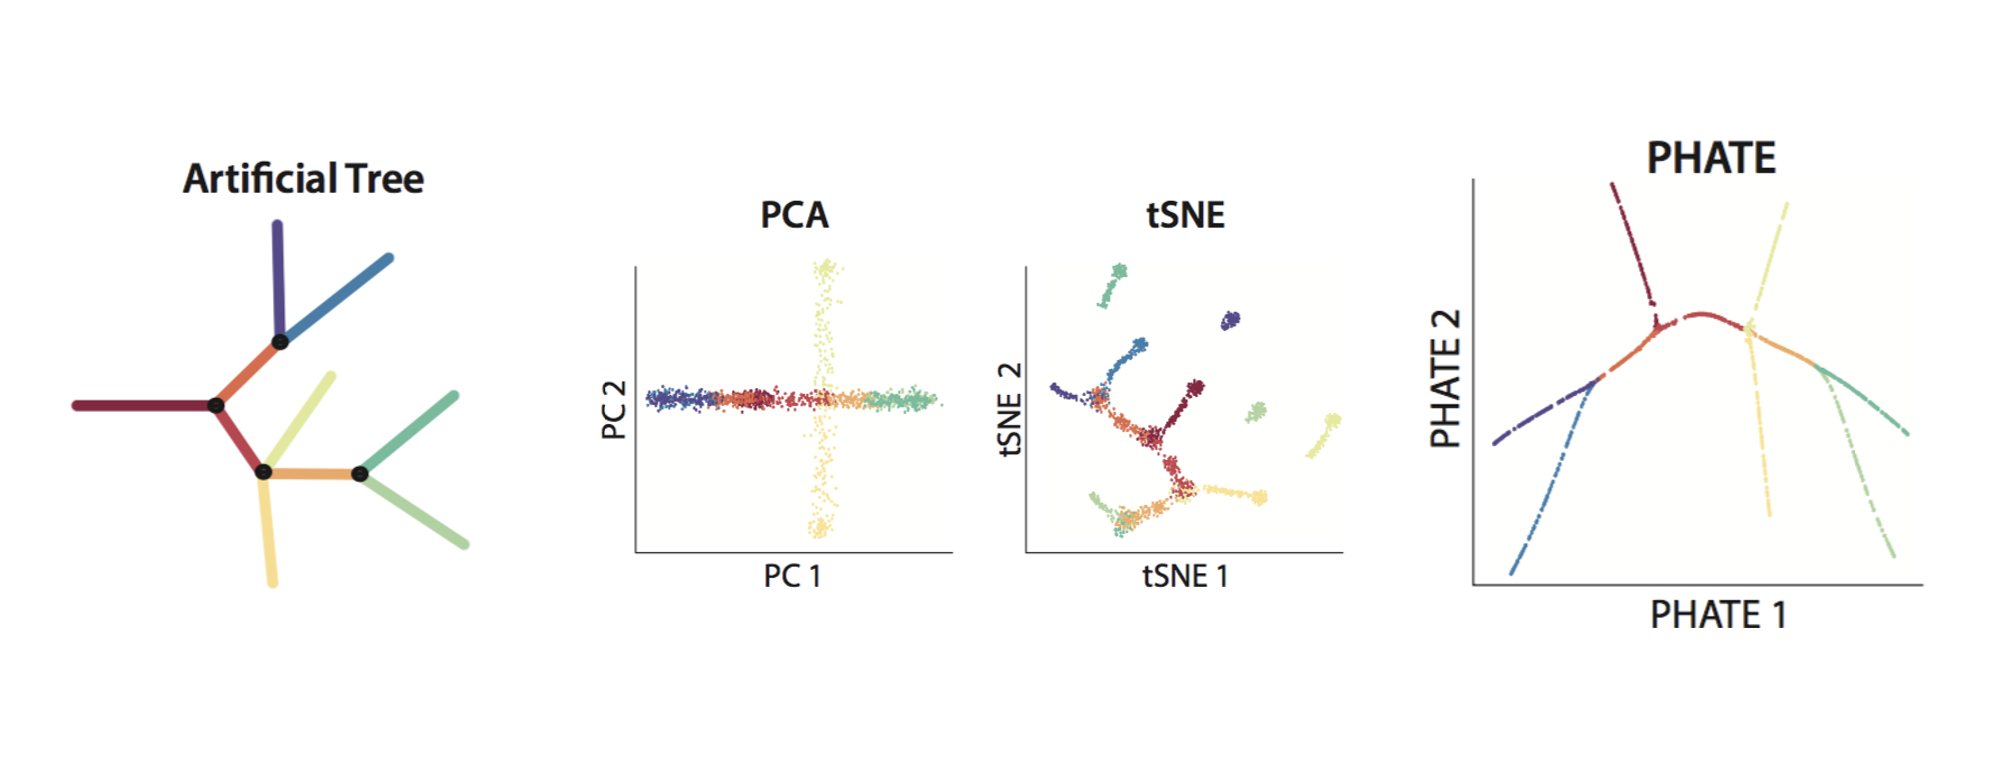

## algorithm

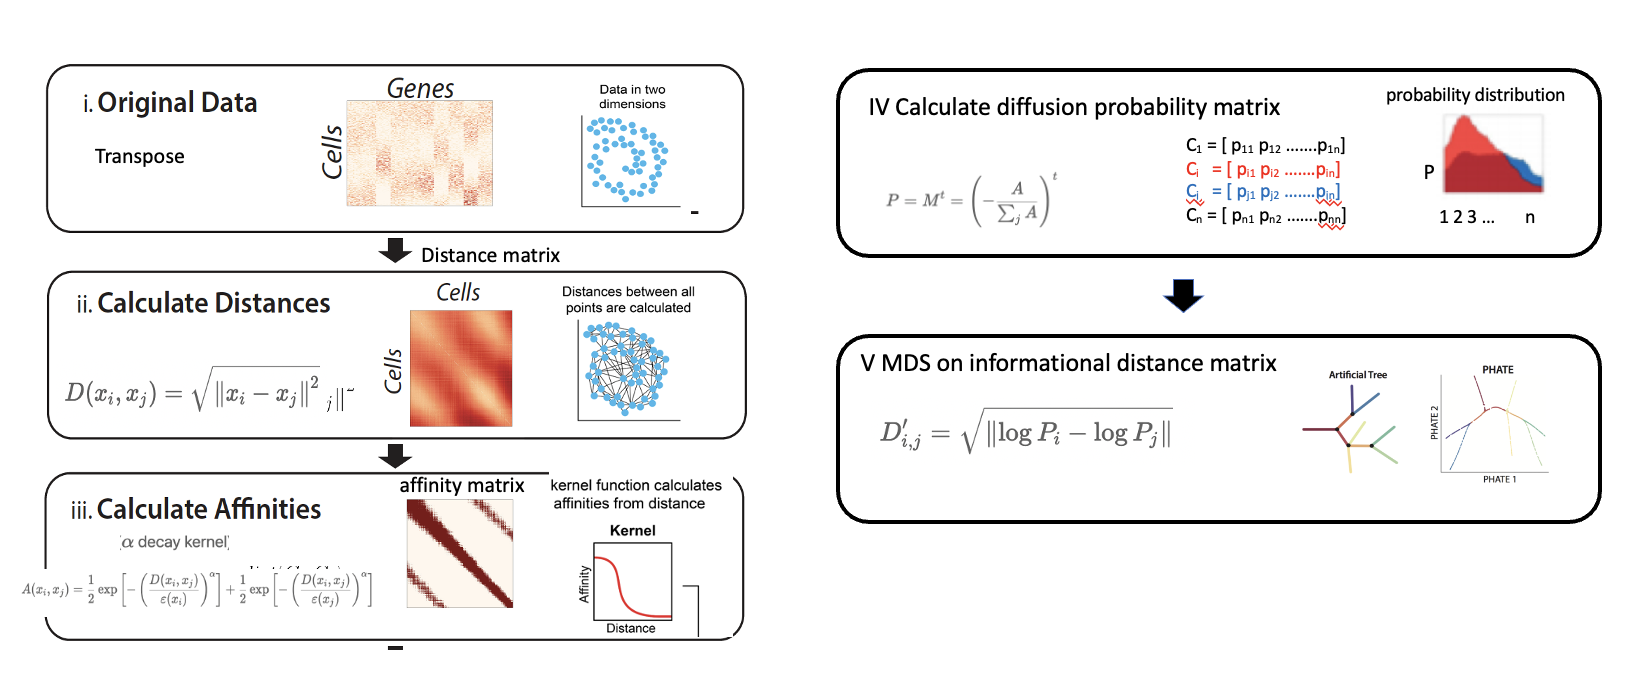

the first 4 steps are the same as diffusion map


1. input data matrix (rotate)


2. calculate distance matrix (Euclidean distance)


3. calculate affinity matrix (apply $\alpha$ decay kernel)


4. calculate diffusion probability matrix (Powered Markov matrix)


5. calculate informational distance matrix (apply log damping factor)


6. embed informational distance matrix with metric MDS

### step 1: input data matrix (rotate)

- original data matrix $X \in \mathbb{R}^{n \times p}$ has n rows of cells and p columns of genes


- for downstream operations, transpose data matrix to $X \in \mathbb{R}^{p \times n}$

### step 2: calculate distance matrix (Euclidean distance)

- as diffusion map, we calculate pairwise Euclidean distance between our data points (cells) to obtain a distance matrix $D \in \mathbb{R}^{n \times n}$

$$
D_{i,j}=\sqrt{\left \| Cell_i-Cell_j \right \|} \in \mathbb{R}
$$

where $D_{i,j}$ is Euclidean distance between the ith cell and the jth cell

### step 3: calculate affinity matrix ($\alpha$ decay kernel)

- then we apply $\alpha$ decay kernel to distance matrix to obtain affinity matrix $A \in \mathbb{R}^{n \times n}$


- $\alpha$ decay kernel is similar as Gaussian kernel, but was powered to a high degree $\alpha$ and have adaptive bandwidth $\varepsilon(x_i), \varepsilon(x_j)$

$$
A(x_i, x_j) = \frac{1}{2}\exp \left[- \left( \frac{D(x_i, x_j) }{\varepsilon(x_i)}\right)^{\alpha}\right] +  \frac{1}{2}\exp \left[- \left( \frac{D(x_i, x_j) }{\varepsilon(x_j)}\right)^{\alpha}\right]
$$

- adaptive bandwidth $\varepsilon(x)$ is kNN distance of $x$

- $\alpha = 2$ is Gaussian kernel

### step 4: calculate diffusion probability matrix

- Markov normalize the affinity matrix $A$ by row sum of affinity matrix to get diffusion operators $M$,


- then take t steps random walk to power the diffusion operators, we get **powered Markov matrix** $P \in \mathbb{R}^{n \times n}$

$$
P=M^t = \left(-\frac{A}{\sum_j A}\right)^t
$$


- the rows of diffusion operators contain diffusion probabilities (transition probabilities) from one point to another.

- PHATE has specific choice for $t$: spectral entropy of diffusion operators $M$

    i.e., powered Markov matrix should have as many dims more or less as diffusion operators

- for each data point (cell), there is a **probability distribution**, called **statistical Manifold**

    each cell is represented (contexualized) as a t-step diffusion probability to all other cells

    where the ith cell is ith row of powered Markov matrix $P$
    
    $P_{ij}$ is t-step diffusion probability of ith cell going to jth cell,
    
    the larger the probability, the closer these 2 cells are

$$
C_1 = P_{[1,:]}=\begin{bmatrix}
p_{11} & p_{12} & \cdots  & p_{1n}
\end{bmatrix}
\\[1em]
C_2 = P_{[2,:]}= \begin{bmatrix}
p_{21} & p_{22} & \cdots  & p_{2n}
\end{bmatrix}
\\[1em]
\cdots 
\\[1em]
C_n = P_{[n,:]}= \begin{bmatrix}
p_{n1} & p_{n2} & \cdots  & p_{nn}
\end{bmatrix}
$$

- like global word-context matrix in word embedding algorithm GloVe, PHATE treats this global contextualization (diffusion probabilities) as new features

### step 5: calculate informational distance matrix (apply log damping factor)

- for distance metric of step 6 MDS, PHATE use **M-divergence**, a kind of **Manifold distance**

- the new distance matrix $D' \in \mathbb{R}^{n \times n}$ calculated from log diffusion probabilities is called **informational distance matrix**
$$
D'_{i,j}=\sqrt{\left \| \log P_i-\log P_j \right \|}
$$

- **log damping factor** 阻尼系数: used to preserve global structure of data, which **equalize** impact of both local distances (big probabilities) or global distances (small probabilities)


- PHATE use Manifold distance rather than Euclidean distance bc Euclidean distance only preserves **local** structure

### step 6: embed informational distance matrix with metric MDS

- use MDS to calculate embedding of data matrix that preserve **M-divergence** distance

# close relationship between PHATE and diffusion map

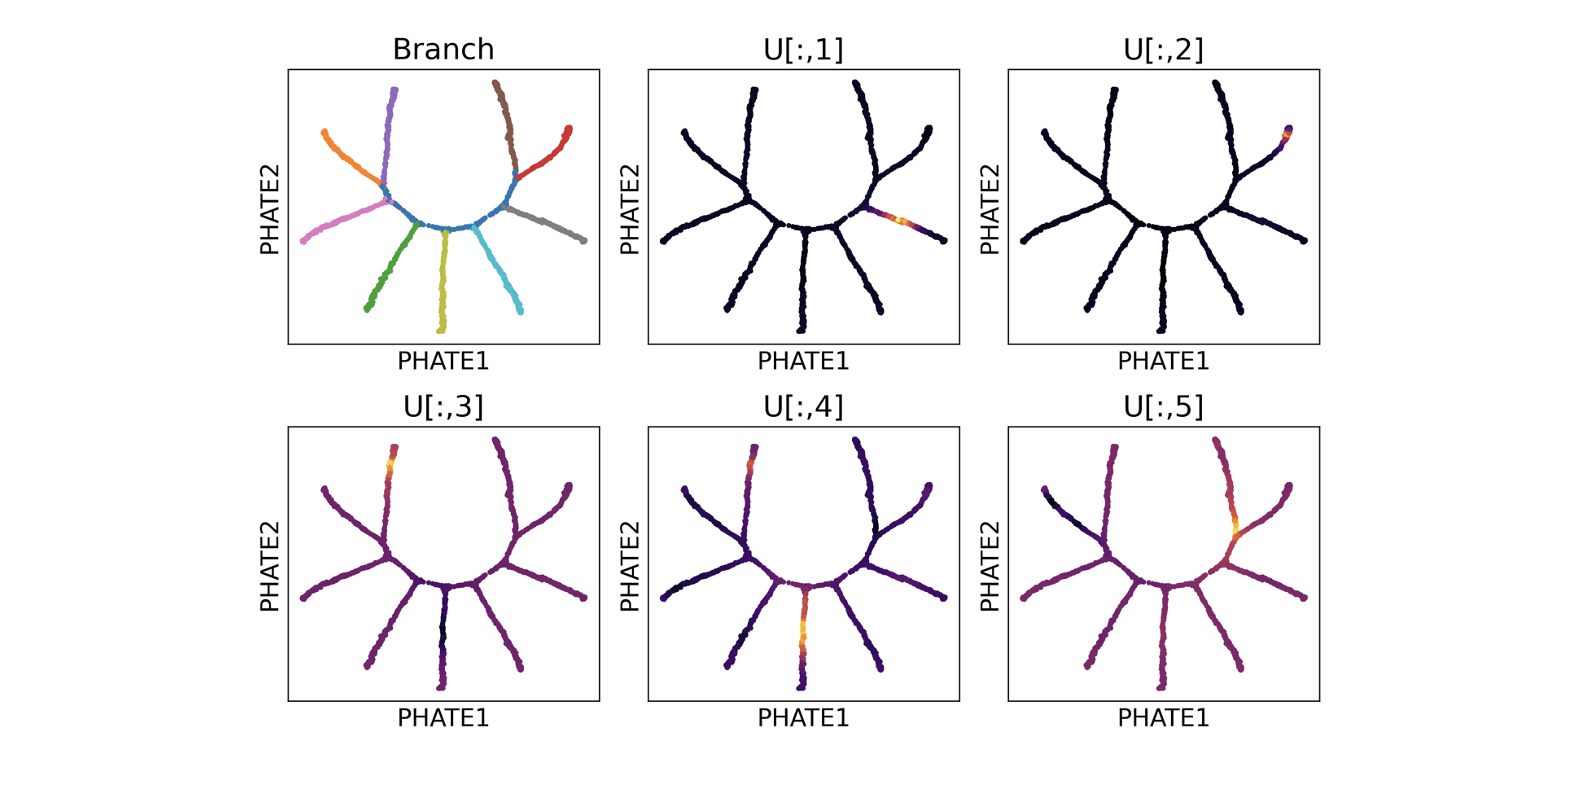

- step 1-4: PHATE = diffusion map

- PHATE and diffusion map play a **complimentary role**, 

    we can color PHATE embeddings with diffusion map to gain more info or extract progression in data
    

- e.g., continue with artificial tree dataset

    - plot 1 (colorful) shows different branching trajectory embedded with PHATE

    - the other 5 plots are also embedded with PHATE but colored by different nontrivial components of diffusion map
    
        - plot 2: the entries of 1st nontrivial component of diffusion map `U[:,1]` are almost 0s, so most branching are black, except a branching with red spot "active", where are non-zero values, means 1st diffusion component encodes this trajectory
        
        - plot 3: explanation is similar for 2rd nontrivial component `U[:,2]` 
        
        - plot 4: explanation is similar for 3rd nontrivial component `U[:,3]` 
        
        ...
   
   
- because diffusion components are orthogonal, 

    diffusion maps put each branching trajectory into **each** different eigen dimensions (so just 1), 
    
    decompose/deinterlace 解除交错 data into different clusters/branches/pads, etc


- PHATE don't do eigendecomposition, collect **all** trajectory into 2D, so we can see relationship of these branches with each other



## hESC dataset

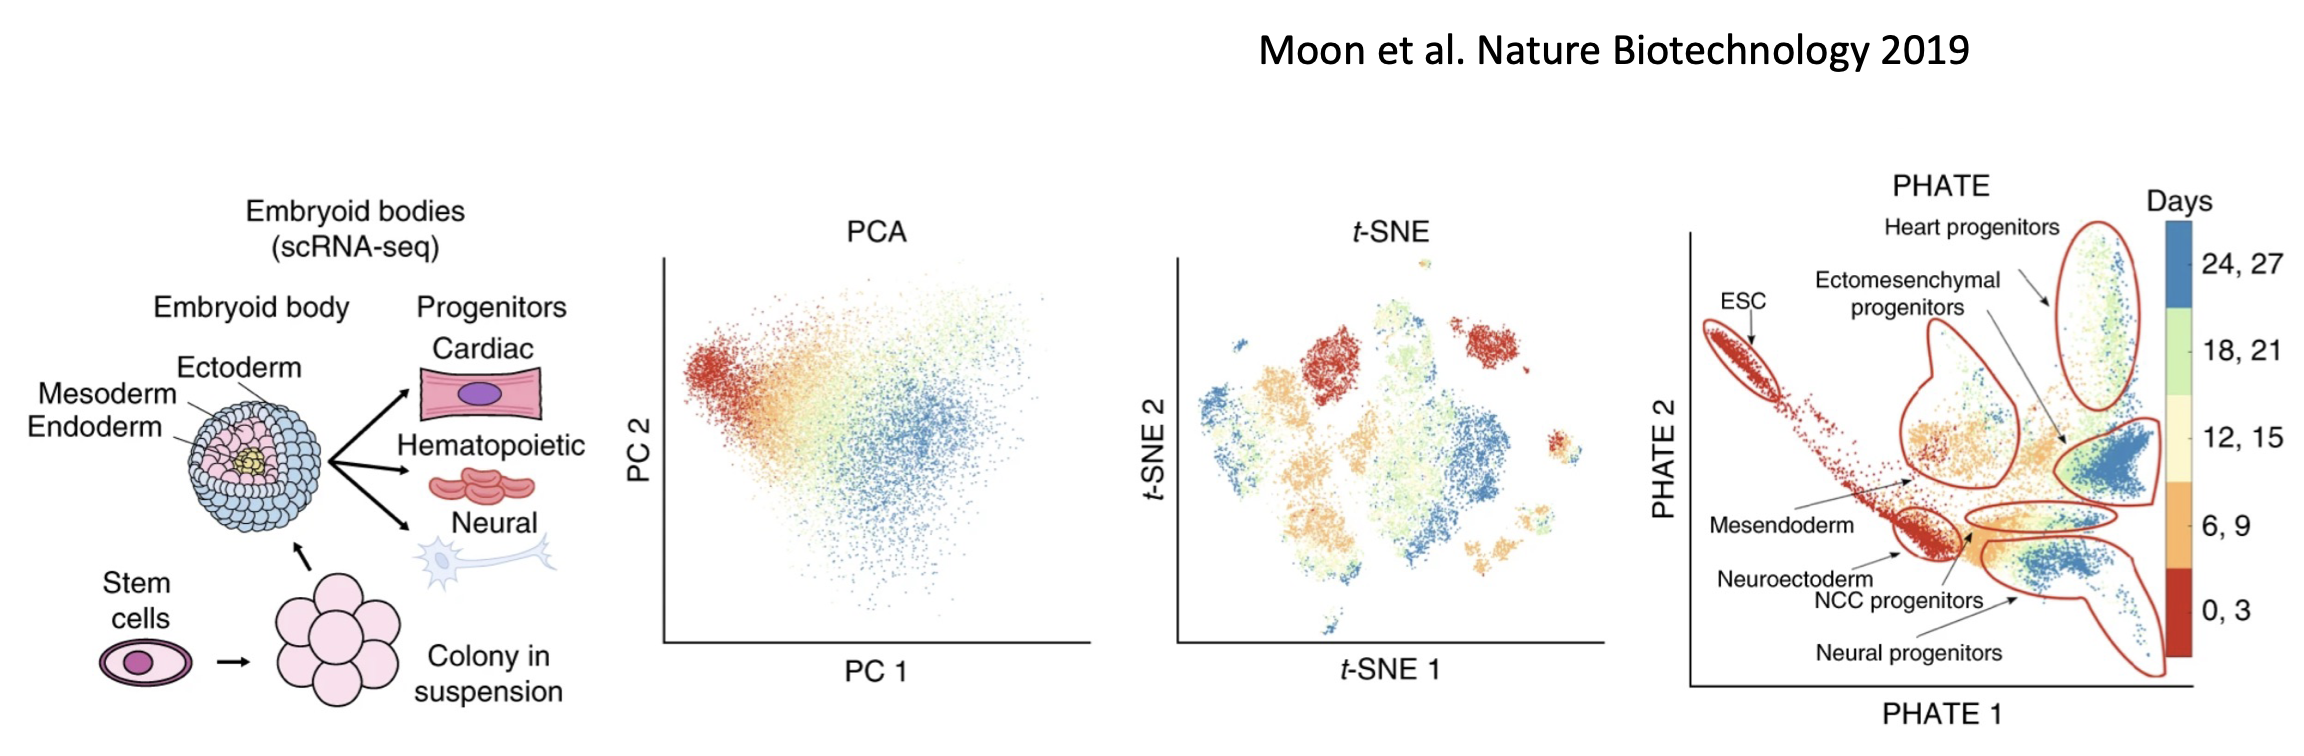

- in the paper, we demonstrate PHATE's functionality on hESC dataset (human embryonic stem cell)


- hESC cell can develop into embryoid bodies and differentiate to different types of cells in 27 days


- we let hESC cell differentiates, harvest cells after 3, 9, 15, 21, 27 days respectively,


- then scRNA-seq these cells to identify their phases of differentiation (**labels**)
    
    
- unsupervised learning: then we use 4 dim reduction methods to embed these cells without labels and visualize them **colored by harvest time**

    - PCA: captures global structure, we can see cells go from 0&3 days (red) to 24&27 days (blue), and the width of cluster becomes wider (divergent linear edges) coz degree of differentiation becomes greater
    
    - t-SNE: shatters 打碎 probability in an area of sparsity and scramble 艰难捕捉 the global structure, did a bad job
    
    - diffusion maps: V shape, mainly store info in 2 trajectories: diffusion component 1 in left-up trajectory and diffusion component 2 in right-up trajectory. we need to look at lots of different diffusion components to learn data structure
    
    - PHATE: do best job, reduce noise in data and give cleaner branching trajectory structure, e.g., we can see 5 blue clusters, these are 5 different types of progenitor 细胞祖先
    
    要求：同种颜色表示同个harvest时期，不仅不同颜色要形成不同聚类，同种颜色也要形成不同聚类，表示不同类型的细胞
    
   

    

## Retinal bipolar cell 

- Retinal bipolar cell dataset 视网膜双极细胞 is a good e.g. of data having many clustering structure


- it has 3 main clusters, PHATE can look inside of these clusters to find progression and subprogression within each cluster


- recently Smita's lab develop an extension of multiscale PHATE that can zoom in to find more subtle structure

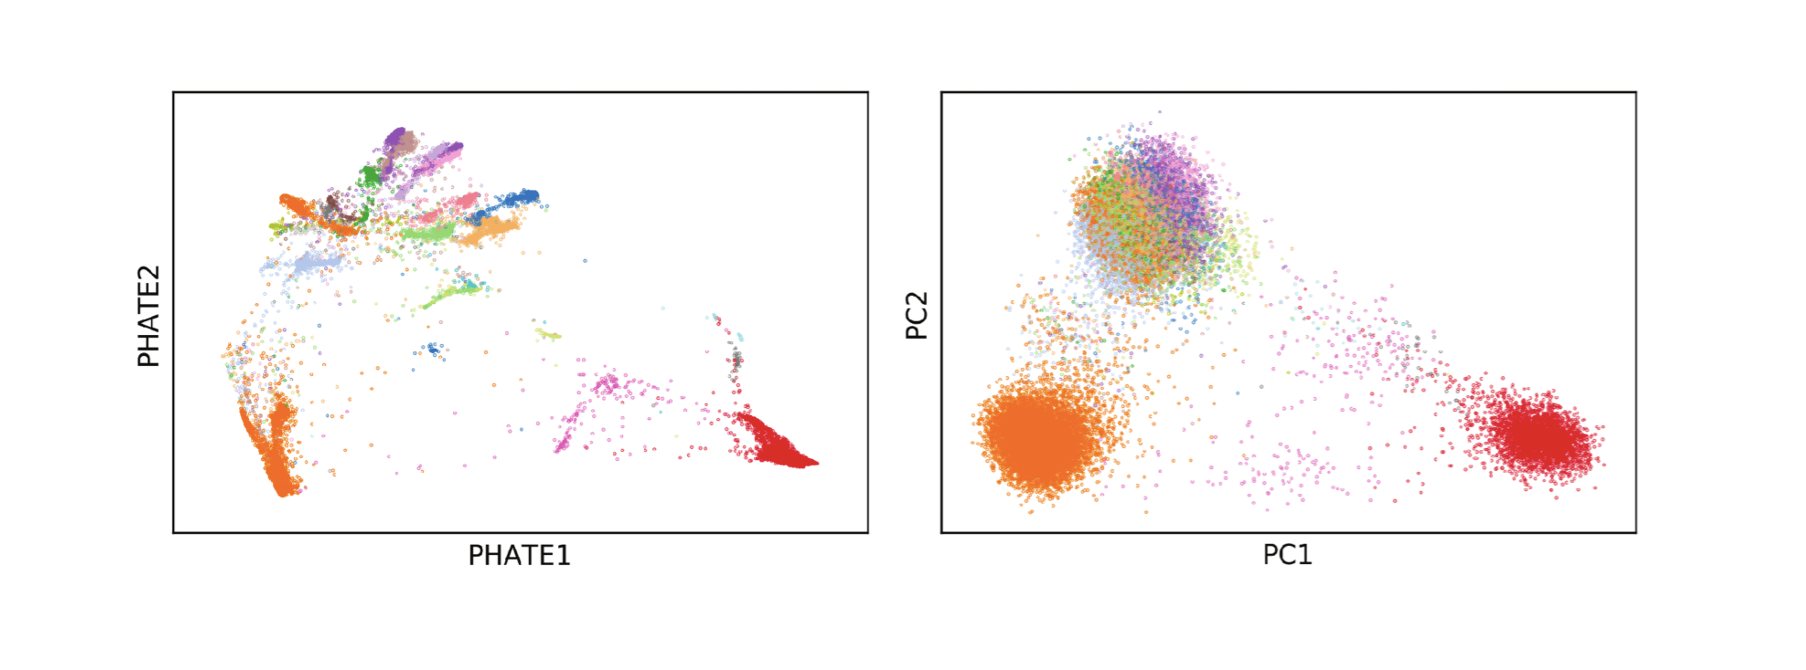